# Modelo base

### Bibliotecas

In [94]:
#Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
import warnings

#Estilizar conteúdo
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    def cor_linhas(row):
        if row.name % 2 == 0:
            return ['background-color: #ffffff'] * len(row)
        else:
            return ['background-color: #f9f9f9'] * len(row)
    
    return (
        df.style.apply(cor_linhas, axis=1)  # Aplica cor alternada às linhas
        .set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},  # Azul abaixo do nome das colunas
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '300px')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},
            ]
        )
        .set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        )
        .set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        )
        .format(
            precision=casas_decimais  
        )
    )

### Base de dados

In [95]:
#Leitura da base de dados

object_columns = ['Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'regiao',
                  'Setores Censitários', 'Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao', 'DA_Polui/cont da água', 'DA_Polui/cont do ar',
                  'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico',
                  "DA_Incêndi parques/APA's/APP's", 'PEPL_Descricao', 'PEPR_Descricao',
                  'Categoria', 'Grupo', 'Subgrupo', 'Tipo', 'Subtipo']

dtype = {col: 'object' for col in object_columns}

df_eventos = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_desastres_rec_nrec.csv",
    sep=';',
    dtype = dtype,
    decimal=',',
)

#Selecionar apenas as variáveis textuais
df_eventos = df_eventos[["Status", "DH_Descricao", "DM_Descricao", "DA_Descricao"]]

#Atribuir valor 0 ao status "Reconhecido" e 1 ao status "Não reconhecido"
df_eventos['Status'] = df_eventos['Status'].map({'Reconhecido': 0, 'Não reconhecido': 1})

#Visualizar amostra de dados
estilo_tabelas(df_eventos.tail(5))

,Status,DH_Descricao,DM_Descricao,DA_Descricao
26253,0,A seca tem causado interrupções no fornecimento de água potável para a população dos núcleos urbanos e limitações severas no consumo de água nos domicílios situados na zona rural que precisam aguardar um tempo elevado para que a água acumule em cisterna em volume que seja possível bombear. _x000D_ _x000D_,nan,Redução dos cursos de água e pastagem provocado pela seca.
26254,0,"Conforme laudo da assistência social, o desastre Tempestade Local/Convectiva - Vendaval atingiu o município em todo o seu território urbano e rural, afetando diretamente 1.180 famílias, aproximadamente 4.716 pessoas, desse total, aproximadamente 30 pessoas ficaram desalojadas. Ainda dentro desse número de famílias 30 famílias foram diretamente afetadas, sendo aproximadamente 120 pessoas encontram-se em vulnerabilidade social. Todos os afetados tiveram danos em suas residências, em telhados, em muitas delas perdendo móveis, roupas e alimentos. Estradas no interior que ficaram sem condições seguras de trafegabilidade e/ou bloqueadas, conforme constatado pela engenharia. A tempestade que atingiu o município afetou as famílias também com a falta de energia elétrica e consequentemente de água, sendo restabelecida em todo o território do município somente no dia 02 de Janeiro.","Conforme laudo da engenharia o evento vendaval causou danos em aproximadamente 30 unidades habitacionais, 01 instalação pública de saúde, uma de ensino e ainda nas estradas rurais do município.",Os danos ambientais recorrem da grande quantidade de lixo produzido pela quebra das telhas de fibrocimento e queda de árvores.
26255,0,"Conforme laudo da assistência social, 20 famílias, 80 pessoas ficaram desalojadas devido destelhamento das suas residências, sendo que três moradias teve todo telhado arrancado, com tesouras e forro. No total foram 276 unidades habitacionais danificadas conforme laudo da engenharia. Ainda conforme laudo da Emater em anexo, houve prejuízos na pecuária que chegam ao valor de R$ 132.000,00.","Conforme laudo da engenharia foram danificadas 276 unidades habitacionais, 07 instalações públicas de ensino sofreram destelhamento devidos aos fortes ventos.",Os danos ambientais recorrem da grande quantidade de lixo produzido pelas quebra das telhas de fibrocimento e quedas de inúmeras árvores.
26256,0,"As pessoas atingidas, tiveram os telhados de suas residências danificados, moveis molhados, sendo necessário cobrir com lonas, totalizando num total de 300 pessoas atingidas diretamente, de acordo com o laudo da assistência social.","De acordo com o laudo da engenharia civil, houve um total de 75 unidades habitacionais atingidas, totalizando um dano estimado de R$120.583,50. Além disso, foi registrado danos causados em prédios públicos, como postos de saúde, escolas, secretarias, totalizando um valor estimado de R$106.834,65.",nan
26257,0,"Toda a população do Município foi afetada direta ou indiretamente pelo evento adverso do dia 29 de dezembro de 2023, devido aos fortes ventos em todo teritório do Município de Ubiretama, que causaram vários destelhamentos em residências e prédios públicos, queda de galhos e árvores sobre as vias municipais, assim dificultando a locomoção das pessoas, bem como interrupçao de fornecimento de energia elétrica, sendo que todo município de Ubiretama está sem energia elétrica até o momento, o que pode perdurar por vários dias inclusive.","Várias residências afetadas, causando um valor aproximado de R$ 10.000,00(dez mil reais), e a quadra de futebol society, que foi teve a cobertura totalmente destruída, em razão dos fortes ventos, causando um prejuízo aproximado de R$ 250.000,00(duzentos e cinquenta mil reais), de acordo com o Relatório do Engenheiro Civil.",nan


Por haver muitos dados ausentes (conforme capítulo "Análise exploratória dos dados") e não necessariamente haver coincidência sobre em quais descrições estarão os dados ausentes, vamos separar as bases de dados para as descrições que se referem aos danos humanos, aos danos materiais e aos danos ambientais.

In [96]:
df_DH_Descricao = df_eventos[['Status', 'DH_Descricao']].dropna(subset=['Status', 'DH_Descricao'])

df_DM_Descricao = df_eventos[['Status', 'DM_Descricao']].dropna(subset=['Status', 'DM_Descricao'])

df_DA_Descricao = df_eventos[['Status', 'DA_Descricao']].dropna(subset=['Status', 'DA_Descricao'])

print('Dimensões das bases de dados: \n')
print('Descrição dos danos humanos:', df_DH_Descricao.shape)
print('Descrição dos danos materiais:',df_DM_Descricao.shape)
print('Descrição dos danos ambientais:',df_DA_Descricao.shape)

Dimensões das bases de dados: 

Descrição dos danos humanos: (19656, 2)
Descrição dos danos materiais: (13756, 2)
Descrição dos danos ambientais: (16078, 2)


#### Verificar o balanceamento das classes

In [97]:
print('Balanceamento das classes: \n')
print('Balanceamento em "danos humanos:', df_DH_Descricao['Status'].value_counts())
print('Balanceamento em "danos materiais:', df_DM_Descricao['Status'].value_counts())
print('Balanceamento em "danos ambientais:', df_DA_Descricao['Status'].value_counts())

Balanceamento das classes: 

Balanceamento em "danos humanos: Status
0    17764
1     1892
Name: count, dtype: int64
Balanceamento em "danos materiais: Status
0    12181
1     1575
Name: count, dtype: int64
Balanceamento em "danos ambientais: Status
0    14719
1     1359
Name: count, dtype: int64


As classes estão desbalanceadas nas três bases de dados (descrição de danos humanos, descrição de danos materiais e descrição de danos ambientais). Em todas as bases, a classe "Reconhecido" (0) é mais proemiente do que a classe "Não reconhecido" (1).

Para resolver este problema, inicialmente vamos utilizar a métrica "f1 score" para comprar os resultados.

### Modelo para "Descrição de danos humanos"

#### Treino e teste

In [98]:
X_train_humanos, X_test_humanos, y_train_humanos, y_test_humanos = train_test_split(df_DH_Descricao['DH_Descricao'], df_DH_Descricao['Status'], test_size=0.2, random_state=1, stratify=df_DH_Descricao['Status'])

print('Exemplo de texto descritivo em danos humanos:\n', X_train_humanos[9788])


Exemplo de texto descritivo em danos humanos:
 Como consequência da estiagem o município tem sido bastante afetado principalmente no que diz respeito à prejuízos na agricultura de subsistência, pecuária e a falta de água potável para consumo humano.


#### Instanciamento do modelo e treinamento do classificador

In [99]:
# Instanciamento do transform CountVectorizer
tfidf_vectorizer_humanos = TfidfVectorizer()

# Tokenização e criação do vocabulário

tfidf_vectorizer_humanos.fit(X_train_humanos)

print('Vocabulário para danos humanos: ')
print(tfidf_vectorizer_humanos.vocabulary_)

Vocabulário para danos humanos: 
{'como': 9324, 'consequência': 9718, 'da': 10598, 'estiagem': 13340, 'município': 19417, 'tem': 26018, 'sido': 24970, 'bastante': 7016, 'afetado': 4774, 'principalmente': 22234, 'no': 19755, 'que': 22781, 'diz': 12026, 'respeito': 23737, 'prejuízos': 22090, 'na': 19525, 'agricultura': 4920, 'de': 10711, 'subsistência': 25478, 'pecuária': 20881, 'falta': 13866, 'água': 28021, 'potável': 21899, 'para': 20566, 'consumo': 9854, 'humano': 15644, 'decreto': 10780, 'emergência': 12546, 'devido': 11659, 'as': 6197, 'chuvas': 8867, 'nº': 19900, '162': 864, '2021': 1236, 'apresenta': 5816, 'houve': 15614, 'aumento': 6575, 'cratera': 10285, 'se': 24577, 'formou': 14402, 'margens': 18464, 'barragem': 6944, 'champrão': 8766, 'mais': 18201, 'especificamente': 13162, 'rua': 24157, 'são': 25736, 'mateus': 18607, 'com': 9255, 'coordenadas': 10060, 'geográficas': 14912, '14': 663, '54': 2842, '20': 1198, '41': 2353, '58': 2957, '06': 135, 'qual': 22734, 'afeta': 4765, 'c

#### Treinamento do classificador

In [100]:
pipeline_humanos = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(loss='log_loss')),
])

classificador_humanos = pipeline_humanos.fit(X_train_humanos, y_train_humanos)

predicted_humanos = classificador_humanos.predict(X_test_humanos)

classification_report_humanos = metrics.classification_report(y_test_humanos, predicted_humanos, digits=6, target_names=['Reconhecido', 'Não reconhecido'])

print('Classification report para danos humanos: \n')
print(classification_report_humanos)

Classification report para danos humanos: 

                 precision    recall  f1-score   support

    Reconhecido   0.904762  0.999719  0.949873      3554
Não reconhecido   0.800000  0.010582  0.020888       378

       accuracy                       0.904629      3932
      macro avg   0.852381  0.505150  0.485380      3932
   weighted avg   0.894691  0.904629  0.860566      3932



### Modelo para "Descrição de danos materiais"

#### Treino e teste

In [101]:
X_train_materiais, X_test_materiais, y_train_materiais, y_test_materiais = train_test_split(df_DM_Descricao['DM_Descricao'], df_DM_Descricao['Status'], test_size=0.2, random_state=42, stratify=df_DM_Descricao['Status'])

print('Exemplo de texto descritivo em danos materiais: \n', X_train_materiais[23613])

Exemplo de texto descritivo em danos materiais: 
 Houveram danos como perda do acesso terrestre à sede do município, ocasionando intensas dificuldades de locomoção; acesso aos serviços de saúde pública; escoamento da produção agrícola como leite e hortifrutigranjeiros; São 1.200km de estradas vicinais com rachaduras, erosões, desmoronamento, com danos estruturais e perdas de 01 ponte, 01 mata-burro e distribuição do muro da Escola Estadual Padre Pedro Thysen.


In [102]:
print('Proporção de danos em cada classe:')
print('Treino : ',y_train_materiais.shape,'\n', y_train_materiais.value_counts(normalize=True),'\n')
print('Teste : ',y_test_materiais.shape,'\n', y_test_materiais.value_counts(normalize=True))

Proporção de danos em cada classe:
Treino :  (11004,) 
 Status
0    0.885496
1    0.114504
Name: proportion, dtype: float64 

Teste :  (2752,) 
 Status
0    0.885538
1    0.114462
Name: proportion, dtype: float64


#### Instancimaneto do modelo e treinamento do classificador

In [103]:
# Instanciamento do transform CountVectorizer
tfidf_vectorizer_materiais = TfidfVectorizer()

# Tokenização e criação do vocabulário
tfidf_vectorizer_materiais.fit(X_train_materiais)

print('Vocabulário para danos materiais: ')
print(tfidf_vectorizer_materiais.vocabulary_)

Vocabulário para danos materiais: 
{'houveram': 14992, 'danos': 9789, 'como': 8452, 'perda': 21304, 'do': 11010, 'acesso': 3029, 'terrestre': 26611, 'sede': 25024, 'município': 19372, 'ocasionando': 20128, 'intensas': 15729, 'dificuldades': 10760, 'de': 9848, 'locomoção': 17507, 'aos': 4260, 'serviços': 25299, 'saúde': 24880, 'pública': 22893, 'escoamento': 12155, 'da': 9680, 'produção': 22580, 'agrícola': 3490, 'leite': 17151, 'hortifrutigranjeiros': 14961, 'são': 26167, '200km': 824, 'estradas': 12520, 'vicinais': 28136, 'com': 8401, 'rachaduras': 23123, 'erosões': 12095, 'desmoronamento': 10426, 'estruturais': 12574, 'perdas': 21307, '01': 52, 'ponte': 22014, 'mata': 18372, 'burro': 6475, 'distribuição': 10925, 'muro': 19399, 'escola': 12165, 'estadual': 12392, 'padre': 20580, 'pedro': 21180, 'thysen': 26675, '10': 248, 'dez': 10702, 'residências': 23892, 'entre': 11944, 'danificadas': 9757, 'destruídas': 10583, 'por': 22065, 'alagamentos': 3589, 'em': 11568, 'virtude': 28277, 'elev

#### Treinamento do classificador

In [104]:
pipeline_materiais = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(loss='log_loss')),
])

classificador_materiais = pipeline_materiais.fit(X_train_materiais, y_train_materiais)

predicted_materiais = classificador_materiais.predict(X_test_materiais)

classification_report_materiais = metrics.classification_report(y_test_materiais, predicted_materiais, digits=6, target_names=['Reconhecido', 'Não reconhecido'])

print('Classification report para danos materiais: \n')
print(classification_report_materiais)

Classification report para danos materiais: 

                 precision    recall  f1-score   support

    Reconhecido   0.886099  0.999179  0.939248      2437
Não reconhecido   0.500000  0.006349  0.012539       315

       accuracy                       0.885538      2752
      macro avg   0.693049  0.502764  0.475894      2752
   weighted avg   0.841905  0.885538  0.833175      2752



### Modelo para "Descrição de danos ambientais"

#### Treino e teste

In [105]:
X_train_ambiental, X_test_ambiental, y_train_ambiental, y_test_ambiental = train_test_split(df_DA_Descricao['DA_Descricao'], df_DA_Descricao['Status'], test_size=0.2, random_state=42, stratify=df_DA_Descricao['Status'])
print('Exemplo de texto descritivo em danos ambientais:', X_train_ambiental[13282])

Exemplo de texto descritivo em danos ambientais: Em virtude da diminuição da capacidade de vazão dos poços artesianos, o abastecimento na zona rural e urbana já começam a sentir os efeitos do abastecimento de água, forçando o município a aumentar o abastecimento na zona rural e perímetro sub urbano com carros pipas para amenizar a situação de falta de água nas áreas acima citadas. Podemos citar também o seguinte: 1- Empobrecimento do solo devido a incidência direta dos raios solares; 02- Absorção de umidade do solo devido a características do solo; 03- Poluição dos mananciais de superfície devido ao baixo acumulo de água, fator que leva a contaminação devido a frequência de animais que fazem uso dessa água para beber e ao mesmo tempo depositam desjeitos.


In [106]:
print('Proporção de dados em cada classe:')
print('Treino : ',y_train_ambiental.shape,'\n', y_train_materiais.value_counts(normalize=True),'\n')
print('Teste  : ',y_test_ambiental.shape,'\n', y_test_materiais.value_counts(normalize=True))

Proporção de dados em cada classe:
Treino :  (12862,) 
 Status
0    0.885496
1    0.114504
Name: proportion, dtype: float64 

Teste  :  (3216,) 
 Status
0    0.885538
1    0.114462
Name: proportion, dtype: float64


#### Instanciamento do modelo e treinamento do classificador

In [107]:
# Instanciamento do transform CountVectorizer
tfidf_vectorizer_ambiental = TfidfVectorizer()

# Tokenização e criação do vocabulário
tfidf_vectorizer_ambiental.fit(X_train_ambiental)

print('Vocabulário para danos ambientais: ')
print(tfidf_vectorizer_ambiental.vocabulary_)

Vocabulário para danos ambientais: 
{'nas': 11031, 'comunidades': 4450, 'rurais': 14180, 'houve': 8524, 'morte': 10839, 'de': 5295, 'animais': 2025, 'domésticos': 6213, 'criações': 5060, 'ainda': 1662, 'destruição': 5828, 'total': 15580, 'fossas': 7824, 'das': 5284, 'residencias': 13841, 'que': 13247, 'transbordaram': 15647, 'contaminando': 4754, 'as': 2424, 'águas': 16499, 'dos': 6223, 'rios': 14062, 'poços': 12658, 'artesianos': 2410, 'em': 6416, 'consequência': 4615, 'da': 5231, 'reduzida': 13578, 'precipitação': 12714, 'pluviométrica': 12390, 'registrada': 13646, 'no': 11166, 'período': 12153, '2018': 351, 'os': 11544, 'mananciais': 10207, 'não': 11267, 'foram_x000d_': 7753, 'repostos': 13777, 'alta': 1814, 'temperatura': 15338, 'tem': 15333, 'contribui': 4844, 'do': 6177, 'para': 11690, 'agravamento': 1566, 'exaurimento': 7218, 'hídrico': 8564, '_x000d_': 1136, 'função': 7964, 'baixo': 2806, 'índice': 16535, 'pluviométrico': 12392, 'observa': 11303, 'se': 14402, 'cursos': 5176, 'á

#### Treinamento do classificador

In [108]:
pipeline_ambiental = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(loss='log_loss')),
])

classificador_ambiental = pipeline_ambiental.fit(X_train_ambiental, y_train_ambiental)

predicted_ambiental = classificador_ambiental.predict(X_test_ambiental)

classification_report_ambiental = metrics.classification_report(y_test_ambiental, predicted_ambiental, digits=6, target_names=['Reconhecido', 'Não reconhecido'])

print('Classification report para danos ambientais: \n')
print(classification_report_ambiental)

Classification report para danos ambientais: 

                 precision    recall  f1-score   support

    Reconhecido   0.918565  1.000000  0.957554      2944
Não reconhecido   1.000000  0.040441  0.077739       272

       accuracy                       0.918843      3216
      macro avg   0.959282  0.520221  0.517646      3216
   weighted avg   0.925452  0.918843  0.883142      3216



### Comparação entre os modelos para danos humanos, materiais e ambientais

#### Métricas de classificação

In [110]:
# Classification report em dicionário
classification_report_ambiental_dict = metrics.classification_report(y_test_ambiental, predicted_ambiental, digits=6, target_names=['Reconhecido', 'Não reconhecido'], output_dict=True)
classification_report_materiais_dict = metrics.classification_report(y_test_materiais, predicted_materiais, digits=6, target_names=['Reconhecido', 'Não reconhecido'], output_dict=True)
classification_report_humanos_dict = metrics.classification_report(y_test_humanos, predicted_humanos, digits=6, target_names=['Reconhecido', 'Não reconhecido'], output_dict=True)

# DataFrame
df_ambiental = pd.DataFrame(classification_report_ambiental_dict).transpose()
df_materiais = pd.DataFrame(classification_report_materiais_dict).transpose()
df_humanos = pd.DataFrame(classification_report_humanos_dict).transpose()

df_ambiental.columns = [f"{col}_ambientais" for col in df_ambiental.columns]
df_materiais.columns = [f"{col}_materiais" for col in df_materiais.columns]
df_humanos.columns = [f"{col}_humanos" for col in df_humanos.columns]

df_comparativo_danos = pd.concat([df_ambiental, df_materiais, df_humanos], axis=1)

# Destacar métrica f1
def highlight_accuracy_f1(row):
    highlight = [''] * len(row)  
    if row.name == 'accuracy':  
        for i, col in enumerate(row.index):  
            if col in ['f1-score_ambientais', 'f1-score_materiais', 'f1-score_humanos']:
                highlight[i] = 'background-color: #FFFF99'
    return highlight


styled_df = df_comparativo_danos.style.apply(highlight_accuracy_f1, axis=1)

styled_df

,precision_ambientais,recall_ambientais,f1-score_ambientais,support_ambientais,precision_materiais,recall_materiais,f1-score_materiais,support_materiais,precision_humanos,recall_humanos,f1-score_humanos,support_humanos
Reconhecido,0.918565,1.000000,0.957554,2944.000000,0.886099,0.999179,0.939248,2437.000000,0.904762,0.999719,0.949873,3554.000000
Não reconhecido,1.000000,0.040441,0.077739,272.000000,0.500000,0.006349,0.012539,315.000000,0.800000,0.010582,0.020888,378.000000
accuracy,0.918843,0.918843,0.918843,0.918843,0.885538,0.885538,0.885538,0.885538,0.904629,0.904629,0.904629,0.904629
macro avg,0.959282,0.520221,0.517646,3216.000000,0.693049,0.502764,0.475894,2752.000000,0.852381,0.505150,0.485380,3932.000000
weighted avg,0.925452,0.918843,0.883142,3216.000000,0.841905,0.885538,0.833175,2752.000000,0.894691,0.904629,0.860566,3932.000000


#### Matriz de confusão

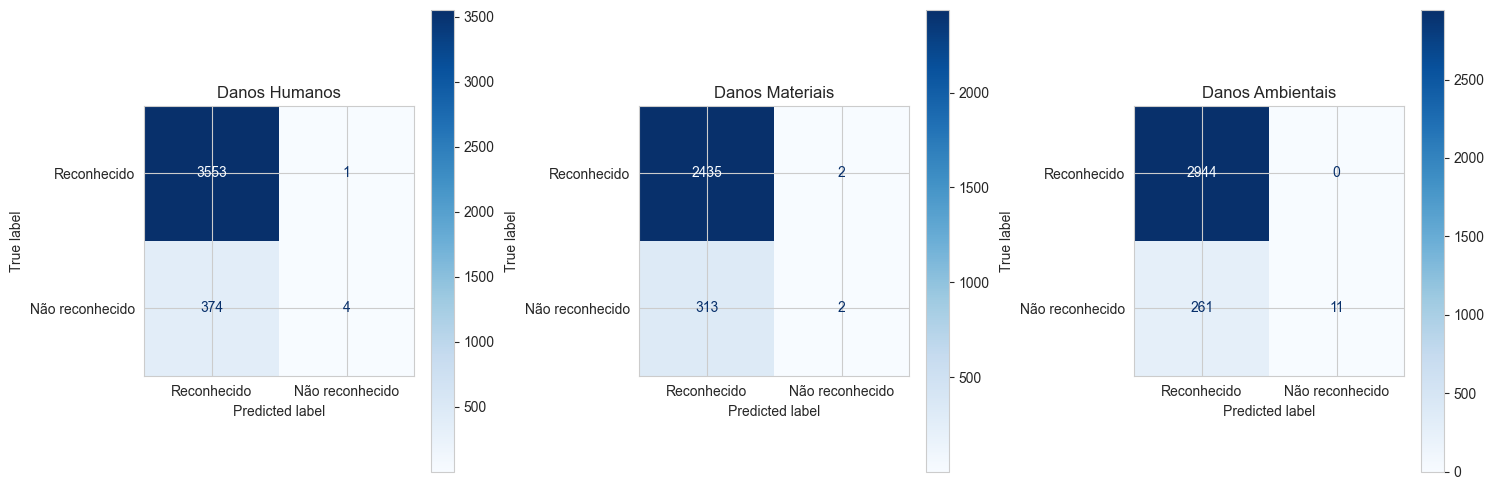

In [93]:
# Configurações
cmap = plt.cm.Blues
labels = ['Reconhecido', 'Não reconhecido']

# Subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

# Matriz de confusão para 'classificador_humanos'
ConfusionMatrixDisplay.from_estimator(classificador_humanos, X_test_humanos, y_test_humanos, 
                                      values_format='d', ax=axes[0], cmap=cmap, display_labels=labels)  # Especifica o subplot 1
axes[0].set_title('Danos Humanos')

# Matriz de confusão para 'classificador_materiais'
ConfusionMatrixDisplay.from_estimator(classificador_materiais, X_test_materiais, y_test_materiais, 
                                      values_format='d', ax=axes[1], cmap=cmap, display_labels=labels)  # Especifica o subplot 2
axes[1].set_title('Danos Materiais')

# Matriz de confusão para 'classificador_ambiental'
ConfusionMatrixDisplay.from_estimator(classificador_ambiental, X_test_ambiental, y_test_ambiental, 
                                      values_format='d', ax=axes[2], cmap=cmap, display_labels=labels)  # Especifica o subplot 3
axes[2].set_title('Danos Ambientais')

# Exibir o gráfico
plt.tight_layout()  # Ajusta os espaçamentos entre os gráficos para evitar sobreposição
plt.show()